In [1]:
import os
import subprocess
import xugrid as xu
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import animation
from mpl_toolkits.basemap import Basemap
import contextily as cx
#import 
%matplotlib inline

In [2]:
base_dir = r'C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\ERA5_data'

# data_dir = os.path.join(base_dir, 'NorthSeanobnd')
data_dir = base_dir
print(data_dir)

C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\ERA5_data


In [ ]:
### Post-process Hurrywave results
# Get the results from the netcdf file

nc_file = os.path.join(data_dir,'mia_waves_2020_2024.nc')
data = xu.open_dataset(nc_file)



[51.9]
[3.  3.5 4.  4.5]


In [ ]:
# (OPTIONAL) Print available parameters in datatory-file
print(f"{'Variable Name':<15} {'Long Name':<65} {'Units':<15} {'Dimensions':<40}")
for var_name, data_array in data.variables.items():
    dimensions = str(data_array.dims)
    long_name = data_array.attrs.get('long_name', 'N/A')
    units = data_array.attrs.get('units', 'N/A')
    print(f"{var_name:<15}  {long_name:<65} {units:<15} {dimensions:<40}")

Variable Name   Long Name                                                         Units           Dimensions                              
mwd2             Mean wave direction of second swell partition                     degrees         ('valid_time', 'latitude', 'longitude') 
number           ensemble member numerical id                                      1               ()                                      
valid_time       time                                                              N/A             ('valid_time',)                         
latitude         latitude                                                          degrees_north   ('latitude',)                           
longitude        longitude                                                         degrees_east    ('longitude',)                          
expver           N/A                                                               N/A             ('valid_time',)                         
swh              Sign

In [ ]:
def load_station_data(data, lat_idx, lon_idx):
    """
    Load all relevant variables at a known station grid point (lat_idx, lon_idx).
    """
    variables = {}
    for var_name in data.data_vars:
        if ('valid_time' in data[var_name].dims and
            'latitude' in data[var_name].dims and
            'longitude' in data[var_name].dims):
            variables[var_name] = data[var_name][:, lat_idx, lon_idx].values
    return variables


In [ ]:
def load_specific_variables(data, variables):
    """
    Extract and return selected wave-related variables from the grid point data.
    """
    data_dt = np.diff(data.valid_time.values).astype('timedelta64[s]').mean().astype(float)
    data_time = data.valid_time.values

    data_hm0 = variables.get('swh', None)             # Significant wave height
    data_tp = variables.get('pp1d', None)             # Peak period
    data_wavdir = variables.get('mwd', None)          # Mean wave direction
    data_dirspr = variables.get('wdw', None)          # Directional spread
    data_wind_speed = variables.get('shww', None)     # Wind wave height
    data_wind_direction = variables.get('mdww', None) # Wind wave direction

    return data_dt, data_time, data_hm0, data_tp, data_wavdir, data_dirspr, data_wind_speed, data_wind_direction

In [14]:
# Load all data at that point
lat_idx = 0
lon_idx = 0
station_vars = load_station_data(data, lat_idx, lon_idx)

# Extract specific variables
data_dt, data_time, data_hm0, data_tp, data_wavdir, data_dirspr, data_wind_speed, data_wind_direction = \
    load_specific_variables(data, station_vars)

print(f"Number of values in data_hm0: {len(data_hm0)}")

Number of values in data_hm0: 43848


In [45]:
def get_number_of_latitude_values(data):
    """
    Get the number of latitude values in the dataset.
    """
    return len(data.latitude.values) if 'latitude' in data.dims else 0

def get_number_of_longitude_values(data):
    """
    Get the number of longitude values in the dataset.
    """
    return len(data.longitude.values) if 'longitude' in data.dims else 0

def get_latitude_values(data):
    """
    Get the latitude values from the dataset.
    """
    return data.latitude.values if 'latitude' in data.dims else None

def get_longitude_values(data):
    """
    Get the longitude values from the dataset.
    """
    return data.longitude.values if 'longitude' in data.dims else None

def get_lat_lon_values(data, lat_idx, lon_idx):
    """
    Get the latitude and longitude values for a specific grid point.
    """
    lat = data.latitude.values[lat_idx] if 'latitude' in data.dims else None
    lon = data.longitude.values[lon_idx] if 'longitude' in data.dims else None
    return lat, lon

def get_lat_lon_values_from_data(data):
    """
    Get the latitude and longitude values from the dataset.
    """
    lat = data.latitude.values if 'latitude' in data.dims else None
    lon = data.longitude.values if 'longitude' in data.dims else None
    return lat, lon

def get_closest_lat_idx_from_coords(data, lat):
    """
    Get the closest latitude index from the dataset for a given latitude coordinate.
    """
    lat_values = get_latitude_values(data)
    if lat_values is not None:
        return np.abs(lat_values - lat).argmin()
    return None

def get_closest_lon_idx_from_coords(data, lon):
    """
    Get the closest longitude index from the dataset for a given longitude coordinate.
    """
    lon_values = get_longitude_values(data)
    if lon_values is not None:
        return np.abs(lon_values - lon).argmin()
    return None

def get_closest_lat_lon_idx_from_coords(data, lat, lon):
    """
    Get the closest latitude and longitude indices from the dataset for given coordinates.
    """
    lat_idx = get_closest_lat_idx_from_coords(data, lat)
    lon_idx = get_closest_lon_idx_from_coords(data, lon)
    return lat_idx, lon_idx

def add_stations_to_dict(station_dict, data, lat_idx, lon_idx):
    """
    Add station metadata (name and coordinates) to the dictionary.
    """
    lat, lon = get_lat_lon_values(data, lat_idx, lon_idx)
    
    # Determine the station name
    if station_dict:
        last_station_name = max(station_dict.keys(), key=lambda k: int(k.replace('station', '')))
        station_number = int(last_station_name.replace('station', '')) + 1
    else:
        station_number = 1
    
    station_name = f'station{station_number:03d}'
    
    # Add station metadata to the dictionary
    station_dict[station_name] = (lat, lon)
    return station_dict

def add_stations_to_dict_from_data(station_dict, data):
    """
    Add all stations to the dictionary using the dataset.
    """
    for lat_idx in range(get_number_of_latitude_values(data)):
        for lon_idx in range(get_number_of_longitude_values(data)):
            station_dict = add_stations_to_dict(station_dict, data, lat_idx, lon_idx)
    return station_dict


def add_stations_to_dict_from_coords(station_dict, data, lat, lon):
    """
    Add station data to the dictionary using latitude and longitude coordinates.
    """
    lat_idx, lon_idx = get_closest_lat_lon_idx_from_coords(data, lat, lon)
    return add_stations_to_dict(station_dict, data, lat_idx, lon_idx)

def add_stations_to_dict_from_coordata_list(station_dict, data, coordata_list):
    """
    Add multiple stations to the dictionary using a list of latitude and longitude coordinates.
    """
    for lat, lon in coordata_list:
        station_dict = add_stations_to_dict_from_coords(station_dict, data, lat, lon)
    return station_dict

def create_station_dict(data):
    """
    Create a dictionary of stations with their latitude and longitude as keys.
    """
    station_dict = {}
    station_dict = add_stations_to_dict_from_data(station_dict, data)
    return station_dict

def print_station_dict(station_dict):
    """
    Print the station dictionary.
    """
    print(f"Number of stations in the dictionary: {len(station_dict)}")
    for station_name, (lat, lon) in station_dict.items():
        print(f"{station_name}: Latitude: {lat}, Longitude: {lon}")

In [ ]:
station_dict = create_station_dict(data)

print_station_dict(station_dict)

Number of stations in the dictionary: 4
station001: Latitude: 51.9, Longitude: 3.0
station002: Latitude: 51.9, Longitude: 3.5
station003: Latitude: 51.9, Longitude: 4.0
station004: Latitude: 51.9, Longitude: 4.5
{'station001': (51.9, 3.0), 'station002': (51.9, 3.5), 'station003': (51.9, 4.0), 'station004': (51.9, 4.5)}


In [49]:
# Plotting function
def plot_data(data, station_dict, show_labels=True):
    """
    Plot time series and map for multiple stations using lat/lon from station_dict.

    Parameters:
        data: xarray.Dataset
        station_dict: dict of {"station_name": (lat, lon)}
        show_labels: bool, optional
            If True, display labels next to station markers on the map. Default is True.
    """
    fig = plt.figure(figsize=(12, 24))
    fig.suptitle('Wave Model Results for Selected Stations', fontsize=16)

    # Add a map subplot at the top
    map_ax = fig.add_axes([0.1, 0.8, 0.8, 0.15])
    m = Basemap(projection='merc', llcrnrlat=50, urcrnrlat=65,
                llcrnrlon=-5, urcrnrlon=10, resolution='i', ax=map_ax)
    m.drawcoastlines()
    m.fillcontinents(color='lightgray', lake_color='aqua')
    m.drawmapboundary(fill_color='aqua')

    # Create subplots
    axs = fig.subplots(6, 1, gridspec_kw={'hspace': 0.5, 'top': 0.75})

    for station_name, (lat, lon) in station_dict.items():
        # Find nearest grid point index
        lat_idx, lon_idx = get_closest_lat_lon_idx_from_coords(data, lat, lon)

        # Get data
        variables = load_station_data(data, lat_idx, lon_idx)
        data_dt, data_time, data_hm0, data_tp, data_wavdir, data_dirspr, data_wind_speed, data_wind_direction = \
            load_specific_variables(data, variables)

        # Plot location on map
        x, y = m(lon, lat)
        m.plot(x, y, 'ro', markersize=8)
        if show_labels:
            map_ax.text(x, y, f' {station_name}', fontsize=8, color='black')

        # Plot time series
        axs[0].plot(data_time, data_hm0, label=f'{station_name}')
        axs[1].plot(data_time, data_tp, label=f'{station_name}')
        axs[2].plot(data_time, data_wavdir, label=f'{station_name}')
        axs[3].plot(data_time, data_dirspr, label=f'{station_name}')

        if data_wind_speed is not None:
            axs[4].plot(data_time, data_wind_speed, label=f'{station_name}')
        if data_wind_direction is not None:
            axs[5].plot(data_time, data_wind_direction, label=f'{station_name}')

    # Titles and labels
    titles = ['Hm0', 'Tp', 'Wave Direction', 'Directional Spread', 'Wind Speed', 'Wind Direction']
    ylabels = ['Hm0 (m)', 'Tp (s)', 'Direction (°)', 'Spread (rad)', 'Speed (m/s)', 'Direction (°)']
    for ax, title, ylabel in zip(axs, titles, ylabels):
        ax.set_title(title)
        ax.set_xlabel('Time')
        ax.set_ylabel(ylabel)
        ax.legend()

    plt.show()


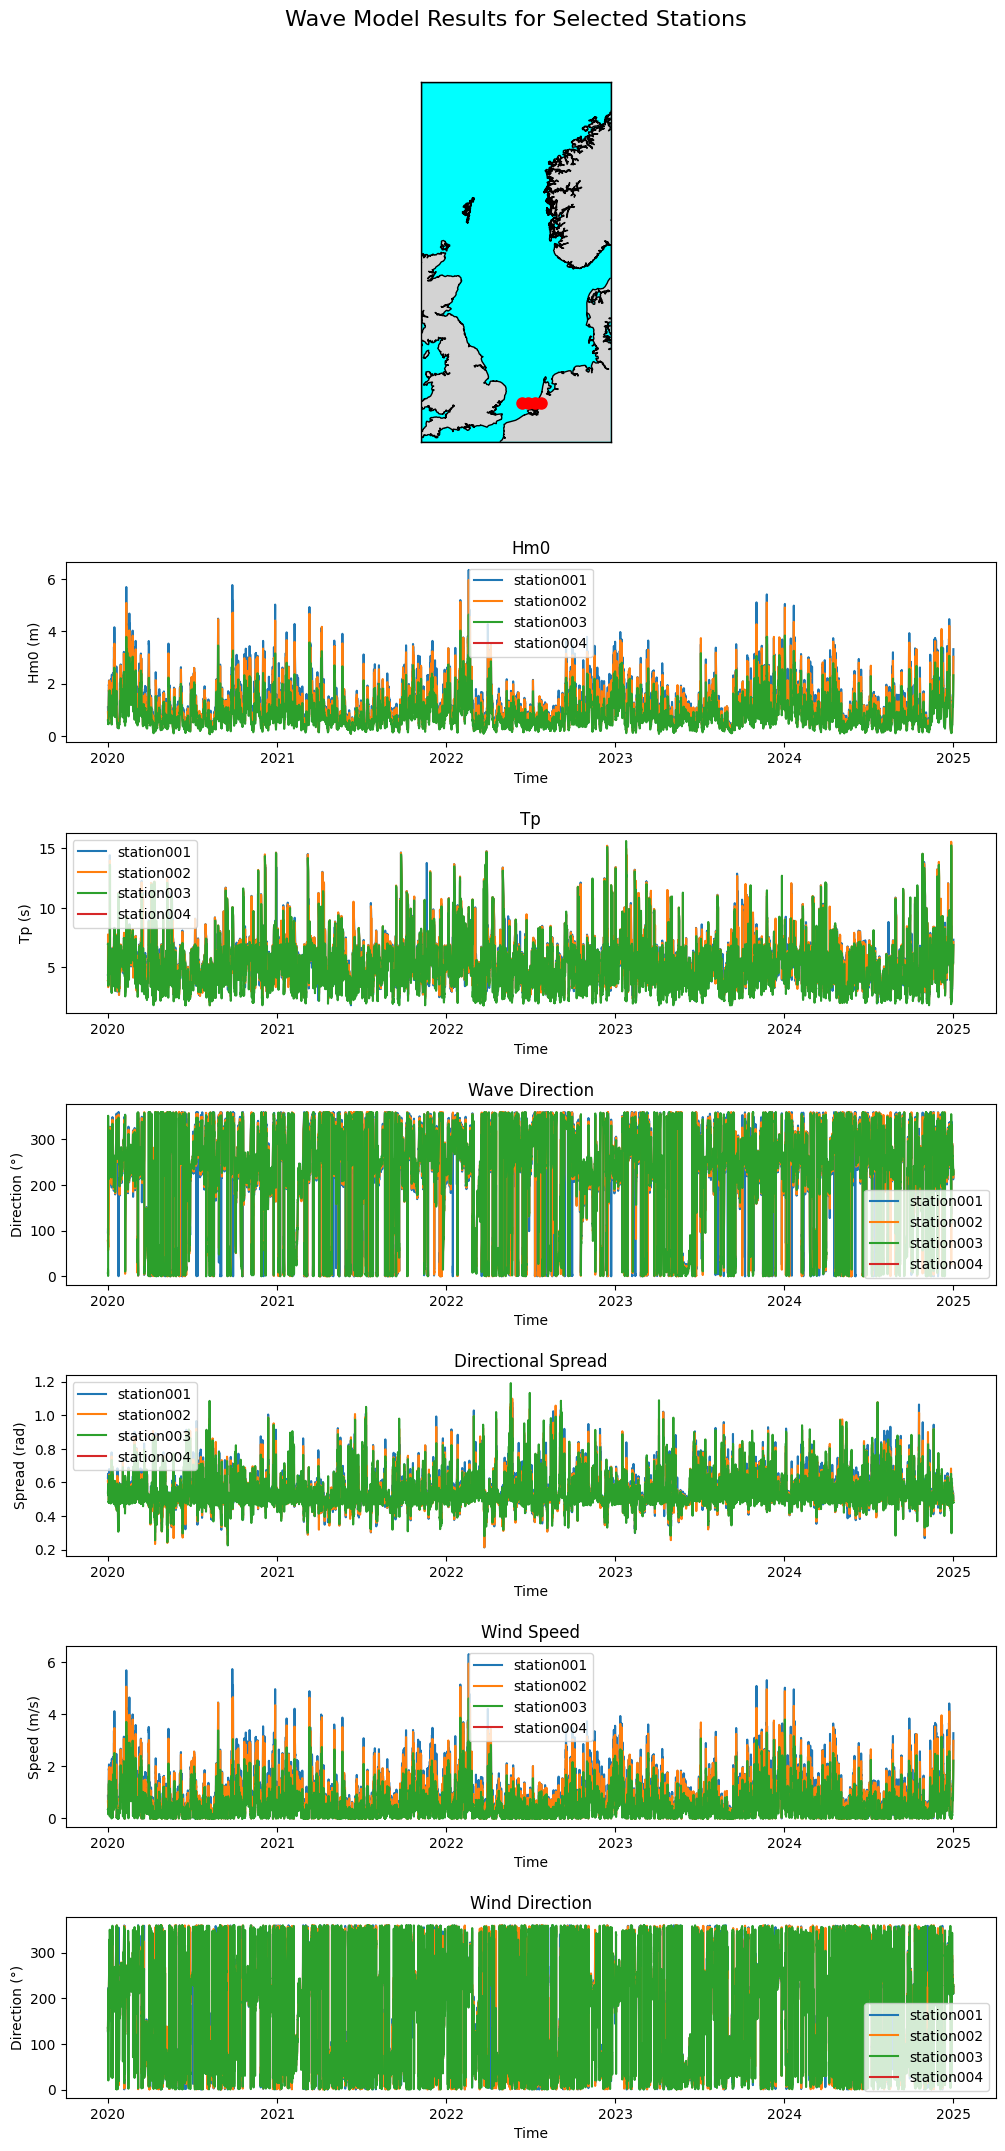

In [50]:
plot_data(data, station_dict, show_labels=False)